# Lab Assignment Seven: Recurrent Network Architectures

***Sahil Johari, Prabhat Pal, Pritheesh Panchmahalkar, Azeem Merchant***
<hr>

# 1.Business Understanding

**Sentiment analysis** - also known as opinion mining - is a process of determining the emotional tone behind a series of words, which is used to gain an understanding of the emotions, attitudes, and opinions expressed within an online remark.


This type of analysis is extremely useful for monitoring social media to gain an idea of public opinion on certain topics or events. Extracting such insights from social media can be of great use to the different organizational sectors across the world. However, this process is not so perfect. There are several other factors which needs to be considered before relying on the results of this analysis completely. Some of the factors are – grammatical nuances, cultural variations, slangs, and misspellings. For a machine to learn how a context can influence the tone of a message is much more difficult to achieve. To understand and capture the true emotions behind words, we need multidimensional scale which is more sophisticated.


In this lab, we are going to perform a straightforward sentiment analysis on some of the tweets posted on Twitter. Based on the tweets, our recurrent neural network models will predict their sentiment (positive or negative). As we are going to use some of the best architectures available in the recurrent neural network as our underlying models, we are expecting a performance of around 80%.


Sentiment analysis may also be useful in training a Natural Language Interface (NLI) to understand user inputs and generate responses. For use in NLI, we think that a baseline accuracy of 70% would be required. This performance would get better as we continually train the model using data that has been collected with use of the interface. It may be helpful in helping computers understand how emotions and feelings work. This would help the computer to understand what kind of emotions the user is feeling when they are giving commands to the interface. It would also help the computer generate its own emotions as well in accordance to the users input and the predicted system output. 


# 2.Data Preparation

We start working on our data set by pulling the CSV file that contains *Sentiment*(negative/positive), and *Sentiment Text* which is used to derive the sentiment values. Because the original data set from **Kaggle** provides separate training and testing sets without test labels in the test set, we shall use the training set as a whole and split into train-test sets.

The following is a list of attributes in the data, their data types, and a brief description of the attribute.

- **ItemID** (int): A unique identifier for a *tweet*
- **Sentiment** (int): A sentiment which could be negative (0) or positive(1)
- **SentimentText** (string object): Text content which was posted as a *tweet* on Twitter

In [1]:
import numpy as np
import matplotlib 
import pandas as pd
import random
import seaborn as sns

import keras
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn import metrics as mt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from scipy import interp

from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
# https://www.kaggle.com/c/twitter-sentiment-analysis2
df = pd.read_csv('dataset/train.csv', encoding="ISO-8859-1")
df = df[:20000]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
ItemID           20000 non-null int64
Sentiment        20000 non-null int64
SentimentText    20000 non-null object
dtypes: int64(2), object(1)
memory usage: 468.8+ KB


In [4]:
df.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [5]:
X = np.array(df['SentimentText'])
y = np.array(df['Sentiment'])

n_samples = X.shape[0]
n_classes = len(np.unique(y))

print("n_samples: {}".format(n_samples))
print("n_classes: {}".format(n_classes))

n_samples: 20000
n_classes: 2


In [6]:
NUM_TOP_WORDS = None
MAX_ART_LEN = 1000 # maximum and minimum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df['SentimentText'])
sequences = tokenizer.texts_to_sequences(df['SentimentText'])

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(y)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 30069 unique tokens. Distilled to 30069 top words.
Shape of data tensor: (20000, 1000)
Shape of label tensor: (20000, 2)
30069


Number of instances: 20000
Number of instances in each class: [10703  9297]


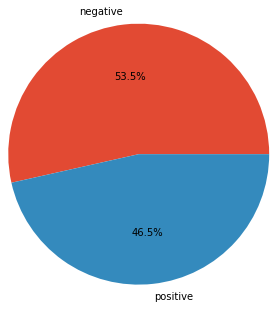

In [7]:
%matplotlib inline
plt.style.use('ggplot')

y_label = ['negative', 'positive']
print('Number of instances:', n_samples)
print('Number of instances in each class:', np.bincount(y))
the_grid = GridSpec(1, 1)

plt.subplot(the_grid[0, 0], aspect=1)
plt.pie(np.bincount(y), labels=y_label, autopct='%1.1f%%', radius=1.5)
plt.show()

**Cross-validation**

According to the results shown above, there seems to be an unequal distribution of data between the two classes (positive & negative). To avoid any biases for class with larger share of data, we will use **Stratified 2-fold cross validation**. As the data that we are using is large (20,000 records) and we are limited by the computational resources (No GPUs involved), we decided to use *2-folds* on our data set. Furthermore, stratification will ensure that the percentages of each class in our entire data will be the same (or very close to) within each individual fold.

**Evaluation Metric**

We are trying to classify tweets into two groups: those which are negative, and those which are positive. Therefore, we want to be careful not to accidentally include any positive tweet into a set of negatives, or otherwise.
Having high *precision* means that when we do say that a tweet is positive, we're usually right about it. This is about how many tweets in our list are actually positive, out of all the ones that we've added to the list.
Having high *recall* means that we can identify most of the positive tweets. This is about how many positive tweets we've added to our list, out of all the ones that exist.
Ideally, we'd want to list all positive tweets that exist while being careful to not accidentally include some which are negative or not positive. If we could do that, then we'd have both high precision and high recall. 

When measuring how well we're doing, it's often useful to have a single number to describe the performance. We could define that number to be, for instance, the mean of the precision and recall - which is **F1 score**.

The evaluation metric for this lab is **Mean F1-Score**. The F1 score measures accuracy using precision (p) and recall (r). Precision is the ratio of true positives (tp) to all predicted positives (tp + fp). Recall is the ratio of true positives to all actual positives (tp + fn). The F1 score is given by:

$$F1 = 2\frac{p . r}{p+r} \space \space where \space p = \frac{tp}{tp+fp} \space and \space r = \frac{tp}{tp+fn}$$  

A good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

**Train-test split**

As mentioned earlier, we will be using the training set *train.csv* as the data set for this lab and split it further into training and testing sets. This is because the test set provided by Kaggle does not contain test labels and we could not figure out how to deal with that. Earlier, we saw that the data is non-uniformly distributed between classes and we are using *stratification* in order to preserve the distribution ratio of the data between classes. For this reason, we will be using **Stratified Shuffle Split** to divide our data. According to our discussion, using Stratified Shuffle Split will compensate for underfitting and improve the results of our model(s).

The reason that we are not splitting the data further is that some more uncommon words would be lesser represented in a smaller dataset. For example, if we are splitting our data into 4 parts, we will have 4,000 words in each of the splits from the training dataset. An uncommon word would have a quarter of the chance to show up in each of these split datasets separately as compared to the unsplit training dataset. According to us, it is better to take a larger training dataset which would have an adequate representation of almost if not all the words in the dictionary as far as text datasets are concerned. 

In [8]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1)

In [9]:
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
y_train_ohe, y_test_ohe = keras.utils.to_categorical(y_train), keras.utils.to_categorical(y_test)

In [10]:
NUM_CLASSES = 2
print(X_train.shape,y_train_ohe.shape)

(16000, 1000) (16000, 2)


In [11]:
# Code reference : https://github.com/smitheric95/machine-learning-labs/blob/master/Lab7
# Added code for capturing values of evaluation metric and plot the graph
def cross_val(cust_model, state_vector_size, embedding_layer, X_train, y_train, splits):
    scores = []
    i = 0
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=64)
    for train, test in skf.split(X_train, y_train):
        # create train and test samples
        x_train = X_train[train]
        y_train_sample = keras.utils.to_categorical(y_train[train])
        x_test = X_train[test]
        y_test_sample = keras.utils.to_categorical(y_train[test])

        rnn = cust_model(state_vector_size, embedding_layer)

        rnn.fit(x_train, y_train_sample, epochs=4, batch_size=64, verbose=0)
        yhat = np.argmax(rnn.predict(x_test), axis=1)

        # capture the scores
        s = mt.f1_score(y_train[test], yhat, average='binary')
        scores.append(s)

        print('Fold: %s, F1-score: %.3f' % (i+1, s))
        i += 1
    print('\nCV score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    plt.bar(range(len(scores)),scores)
    plt.ylim([min(scores)-0.01,max(scores)])

# 3.Modeling

In this section, we are going to build 2 recurrent neural network architectures using **LSTM** and **GRU** models. For one model, we will make use of *GloVe* embedding which is an unsupervised learning algorithm for obtaining vector representations for words. We will also create an embedding from scratch and use it for the other model. For all the models that we build in this lab, we will be using the *Sequential API* of Keras.

### First Recurrent Architecture

In this architecture, we will be using *GRU* network and a custom embedding.

The model consists of a custom embedding with output dimension of 150, followed by
- a dense layer of 200 neurons
- a 25% dropout
- a GRU layer, and 
- a final dense layer for output

Note that the dropout and recurrent dropout were used at 20% for GRU.

In [12]:
def rnn_model1(state_vector_size, embedding_layer):
    
    #create a custom embedding of output dimension 150
    embedding_layer_cust = Embedding(len(word_index) + 1,
                                150,
                                input_length=MAX_ART_LEN,
                                trainable=True,
                                name = "custom_embedding")
    rnn = Sequential()
    rnn.add(embedding_layer_cust)
    rnn.add(Dense(200, activation='relu'))
    rnn.add(Dropout(0.25))
    rnn.add(GRU(state_vector_size, dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='softmax'))
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    return rnn

Fold: 1, F1-score: 0.698
Fold: 2, F1-score: 0.730

CV score: 0.714 +/- 0.016


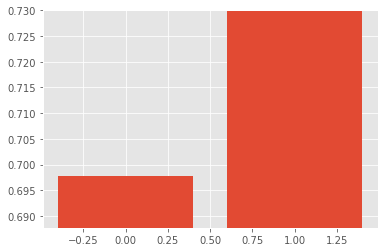

In [13]:
cross_val(rnn_model1, 100, None, X_train, y_train, 2)

In [14]:
rnn_gru = rnn_model1(100, None)
print(rnn_gru.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
custom_embedding (Embedding) (None, 1000, 150)         4510500   
_________________________________________________________________
dense_5 (Dense)              (None, 1000, 200)         30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 200)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 4,631,202
Trainable params: 4,631,202
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
history_gru = rnn_gru.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64)
yhat = np.argmax(rnn_gru.predict(X_test), axis=1)
print("\nF-1 score:", mt.f1_score(y_test, yhat, average='binary'))

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 1640s 103ms/step - loss: 0.5795 - acc: 0.6934 - val_loss: 0.4962 - val_acc: 0.7642
Epoch 2/5
16000/16000 [==============================] - 1642s 103ms/step - loss: 0.4247 - acc: 0.8106 - val_loss: 0.4951 - val_acc: 0.7605
Epoch 3/5
16000/16000 [==============================] - 1635s 102ms/step - loss: 0.3353 - acc: 0.8538 - val_loss: 0.5427 - val_acc: 0.7578
Epoch 4/5
16000/16000 [==============================] - 1641s 103ms/step - loss: 0.2641 - acc: 0.8924 - val_loss: 0.5676 - val_acc: 0.7472
Epoch 5/5
16000/16000 [==============================] - 1649s 103ms/step - loss: 0.2130 - acc: 0.9137 - val_loss: 0.5954 - val_acc: 0.7418

F-1 score: 0.710887209628


### Second Recurrent Architecture

In this architecture, we will be using *LSTM* network and *GloVe* as the embedding.

The model consists of a GloVe embedding with output dimension of 100, followed by
- a dense layer of 500 neurons
- a 30% dropout
- an LSTM layer, and 
- a final dense layer for output

Again, the dropout and recurrent dropout were used at 20% for LSTM. For this architecture, we will also try using GloVe embedding with *output dimension of 200* when we perform hyper-parameter tuning.

In [16]:
def build_embedding(embed_size, file_path):
    EMBED_SIZE = embed_size
    # the embed size should match the file you load glove from
    embeddings_index = {}
    f = open(file_path, encoding='utf8')
    # save key/array pairs of the embeddings
    #  the key of the dictionary is the word, the array is the embedding
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))

    # now fill in the matrix, using the ordering from the
    #  keras word tokenizer from before
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, embeddings_index

In [17]:
EMBED_SIZE_100 = 100
EMBED_SIZE_200 = 200

embedding_matrix_100, embedding_index_100 = build_embedding(EMBED_SIZE_100, 'glove/glove.6B.100d.txt')
embedding_layer_100 = Embedding(len(word_index) + 1,
                            EMBED_SIZE_100,
                            weights=[embedding_matrix_100],
                            input_length=MAX_ART_LEN,
                            trainable=False)

embedding_matrix_200, embedding_index_200 = build_embedding(EMBED_SIZE_200, 'glove/glove.6B.200d.txt')
embedding_layer_200 = Embedding(len(word_index) + 1,
                            EMBED_SIZE_200,
                            weights=[embedding_matrix_200],
                            input_length=MAX_ART_LEN,
                            trainable=False)

Found 400000 word vectors.
Found 400000 word vectors.


In [18]:
def rnn_model2(state_vector_size, embedding_layer):
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(Dense(500, activation='relu'))
    rnn.add(Dropout(0.3))
    rnn.add(LSTM(state_vector_size,dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='softmax'))
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    return rnn

Fold: 1, F1-score: 0.709
Fold: 2, F1-score: 0.594

CV score: 0.652 +/- 0.057


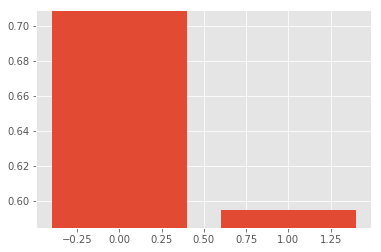

In [19]:
cross_val(rnn_model2, 100, embedding_layer_100, X_train, y_train, 2)

In [20]:
rnn_lstm = rnn_model2(100, embedding_layer_100)
print(rnn_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         3007000   
_________________________________________________________________
dense_11 (Dense)             (None, 1000, 500)         50500     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000, 500)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               240400    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 3,298,102
Trainable params: 291,102
Non-trainable params: 3,007,000
_________________________________________________________________
None


In [21]:
history_lstm = rnn_lstm.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64)
yhat = np.argmax(rnn_lstm.predict(X_test), axis=1)
f1_lstm = mt.f1_score(y_test, yhat, average='binary')
print("\nF-1 score:", f1_lstm)

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 2452s 153ms/step - loss: 0.6200 - acc: 0.6575 - val_loss: 0.5555 - val_acc: 0.7155
Epoch 2/5
16000/16000 [==============================] - 2598s 162ms/step - loss: 0.5466 - acc: 0.7280 - val_loss: 0.5245 - val_acc: 0.7358
Epoch 3/5
16000/16000 [==============================] - 2600s 163ms/step - loss: 0.5190 - acc: 0.7430 - val_loss: 0.5227 - val_acc: 0.7385
Epoch 4/5
16000/16000 [==============================] - 2631s 164ms/step - loss: 0.4944 - acc: 0.7574 - val_loss: 0.5170 - val_acc: 0.7542
Epoch 5/5
16000/16000 [==============================] - 2580s 161ms/step - loss: 0.4759 - acc: 0.7698 - val_loss: 0.5030 - val_acc: 0.7550

F-1 score: 0.732532751092


Comparing both the models based on their training and validation accuracy, and training loss.

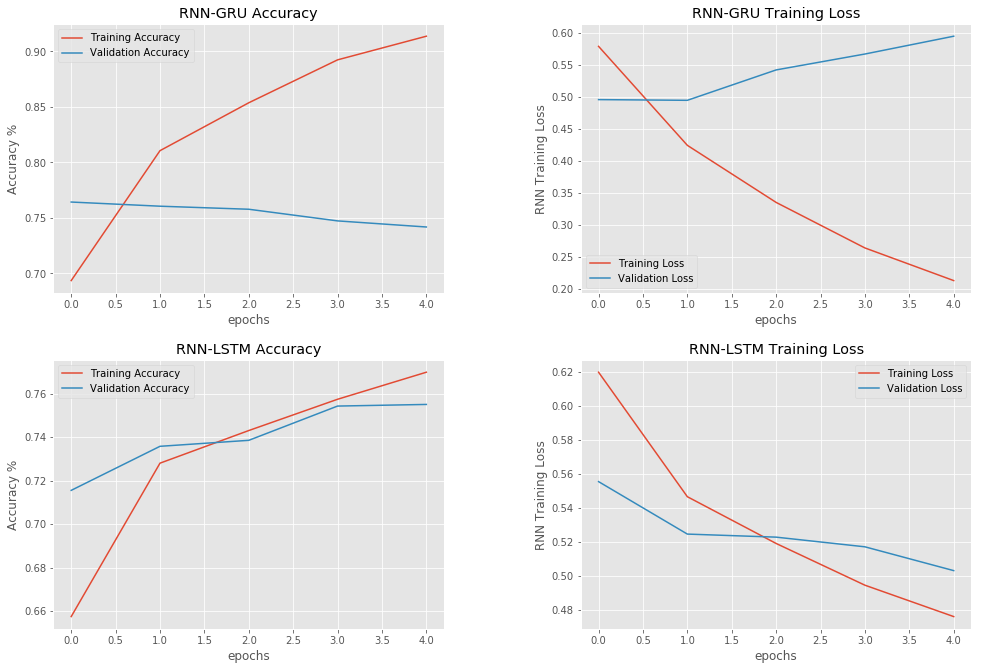

In [22]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.subplot(2,2,1)
plt.plot(history_gru.history['acc'], label="Training Accuracy")
plt.plot(history_gru.history['val_acc'], label="Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy %')
plt.title('RNN-GRU Accuracy')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.plot(history_gru.history['loss'], label="Training Loss")
plt.plot(history_gru.history['val_loss'], label="Validation Loss")
plt.xlabel('epochs')
plt.ylabel('RNN Training Loss')
plt.title('RNN-GRU Training Loss')
plt.legend(loc='best')

plt.subplot(2,2,3)
plt.plot(history_lstm.history['acc'], label="Training Accuracy")
plt.plot(history_lstm.history['val_acc'], label="Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy %')
plt.title('RNN-LSTM Accuracy')
plt.legend(loc='best')

plt.subplot(2,2,4)
plt.plot(history_lstm.history['loss'], label="Training Loss")
plt.plot(history_lstm.history['val_loss'], label="Validation Loss")
plt.xlabel('epochs')
plt.ylabel('RNN Training Loss')
plt.title('RNN-LSTM Training Loss')
plt.legend(loc='best')

Looking at the above graphs, we can see that the RNN-GRU model does good on validation accuracy until 2 epochs after which it starts dropping. Whereas, the RNN-LSTM model is doing better with every epoch. 

Let us tune some of the hyper-parameters for both the models to improve their generalization performance. 

### Adjust hyper-parameters of the networks

We are going to use randomized grid-search to perform this operation. Again, for both the models, we are using 2-fold cross validation in this step.

In [22]:
def RandomizedSearch(rnn_model, param_grid):
    model_k = KerasClassifier(build_fn=rnn_model)
    random_search = RandomizedSearchCV(estimator=model_k, cv=2, param_distributions=param_grid, 
                                       refit=False, verbose=1, n_iter=4)
    random_search_result = random_search.fit(X_train, y_train_ohe)
    return random_search_result

In [23]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [24]:
param_grid = dict(epochs=[2, 4], batch_size=[128, 256], state_vector_size=[150], 
                  embedding_layer=[None])
random_search_result = RandomizedSearch(rnn_model1, param_grid)
report(random_search_result.cv_results_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Epoch 1/2
8000/8000 [==============================] - 873s 109ms/step - loss: 0.6340 - acc: 0.6405
Epoch 2/2
8000/8000 [==============================] - 155s 19ms/step
Epoch 1/2
8000/8000 [==============================] - 1101s 138ms/step - loss: 0.6292 - acc: 0.6350
Epoch 2/2
8000/8000 [==============================] - 170s 21ms/step
Epoch 1/4
8000/8000 [==============================] - 1204s 151ms/step - loss: 0.6400 - acc: 0.6261
Epoch 2/4
8000/8000 [==============================] - 1215s 152ms/step - loss: 0.4503 - acc: 0.8004
Epoch 3/4
8000/8000 [==============================] - 2213s 277ms/step - loss: 0.3220 - acc: 0.8701
Epoch 4/4
8000/8000 [==============================] - 337s 42ms/step
Epoch 1/4
8000/8000 [==============================] - 2750s 344ms/step - loss: 0.6312 - acc: 0.6326
Epoch 2/4
8000/8000 [==============================] - 2745s 343ms/step - loss: 0.4418 - acc: 0.8006
Epoch 3/4
8000/8000 [====

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 786.8min finished


In [25]:
param_grid = dict(epochs=[2, 4], batch_size=[128, 256], state_vector_size=[200], 
                  embedding_layer=[embedding_layer_200])
%time random_search_result = RandomizedSearch(rnn_model2, param_grid)
report(random_search_result.cv_results_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Epoch 1/2
8000/8000 [==============================] - 7924s 991ms/step - loss: 0.6542 - acc: 0.6351
Epoch 2/2
8000/8000 [==============================] - 910s 114ms/step
Epoch 1/2
8000/8000 [==============================] - 4821s 603ms/step - loss: 0.6713 - acc: 0.6144
Epoch 2/2
8000/8000 [==============================] - 940s 118ms/step
Epoch 1/4
8000/8000 [==============================] - 5014s 627ms/step - loss: 0.6566 - acc: 0.6322
Epoch 2/4
8000/8000 [==============================] - 5001s 625ms/step - loss: 0.5831 - acc: 0.6936
Epoch 3/4
8000/8000 [==============================] - 5008s 626ms/step - loss: 0.5357 - acc: 0.7365
Epoch 4/4
8000/8000 [==============================] - 967s 121ms/step
Epoch 1/4
8000/8000 [==============================] - 5073s 634ms/step - loss: 0.6731 - acc: 0.6184
Epoch 2/4
8000/8000 [==============================] - 5109s 639ms/step - loss: 0.5914 - acc: 0.6860
Epoch 3/4
8000/8000 [

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 3315.2min finished


In [23]:
# Train the models using best hyper-parameters 
rnn_gru = rnn_model1(100, None)

print("====Training Model1 (GRU) with best parameters====")
history_gru = rnn_gru.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=2, batch_size=64)
yhat = np.argmax(rnn_gru.predict(X_test), axis=1)
f1_gru = mt.f1_score(y_test, yhat, average='binary')
print("\nF-1 score:", f1_gru)

====Training Model1 (GRU) with best parameters====
Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - 2177s 136ms/step - loss: 0.5757 - acc: 0.6961 - val_loss: 0.5007 - val_acc: 0.7552
Epoch 2/2
16000/16000 [==============================] - 2051s 128ms/step - loss: 0.4264 - acc: 0.8078 - val_loss: 0.4976 - val_acc: 0.7685

F-1 score: 0.741773563859


After tuning the hyper-parameters, we can see that there is some improvement in the performance of RNN-GRU (First architecture). Furthermore, tuning the hyper-parameters for second architecture (RNN-LSTM) did not improve its performance. Therefore, we will be using its base parameters which were used for the first training fit instead of training it again on the best parameters obtained from Grid search above.

Let us compare the two architectures again.

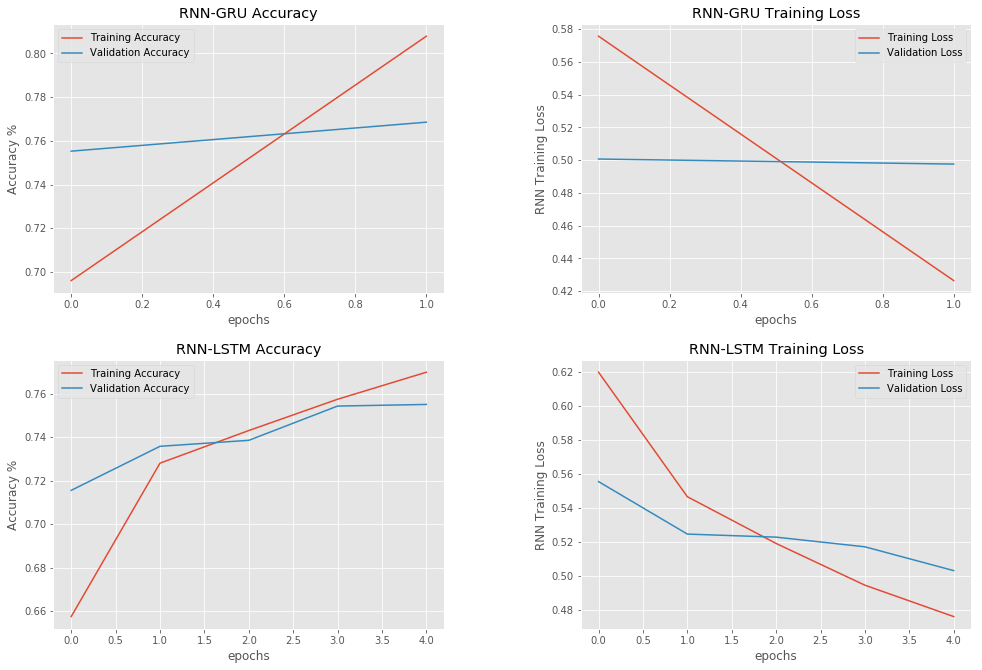

In [26]:
# Visualize Training and validation accuracy versus training iterations again

plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.subplot(2,2,1)
plt.plot(history_gru.history['acc'], label="Training Accuracy")
plt.plot(history_gru.history['val_acc'], label="Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy %')
plt.title('RNN-GRU Accuracy')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.plot(history_gru.history['loss'], label="Training Loss")
plt.plot(history_gru.history['val_loss'], label="Validation Loss")
plt.xlabel('epochs')
plt.ylabel('RNN Training Loss')
plt.title('RNN-GRU Training Loss')
plt.legend(loc='best')

plt.subplot(2,2,3)
plt.plot(history_lstm.history['acc'], label="Training Accuracy")
plt.plot(history_lstm.history['val_acc'], label="Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy %')
plt.title('RNN-LSTM Accuracy')
plt.legend(loc='best')

plt.subplot(2,2,4)
plt.plot(history_lstm.history['loss'], label="Training Loss")
plt.plot(history_lstm.history['val_loss'], label="Validation Loss")
plt.xlabel('epochs')
plt.ylabel('RNN Training Loss')
plt.title('RNN-LSTM Training Loss')
plt.legend(loc='best')

Both the models have rising training and validation accuracies and falling training and validation losses. It is quite straightforward to now compare their F1 scores, which is our evaluation metric for this lab.

In [27]:
%matplotlib inline

def compare_models(rnn1, rnn2, X_test, y_test):
    plt.figure(figsize=(15,5))
    if rnn1 is not None:
        yhat_1 = np.argmax(rnn1.predict(X_test), axis=1)
        acc_1 = mt.f1_score(y_test,yhat_1, average='binary')
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_1)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(pd.DataFrame(cm, y_label, y_label), annot=True, fmt='.2f')
        plt.title('RNN-GRU: '+str(acc_1))
    
    if rnn2 is not None:
        yhat_2 = np.argmax(rnn2.predict(X_test), axis=1)
        acc_2 = mt.f1_score(y_test,yhat_2, average='binary')
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_2)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(pd.DataFrame(cm, y_label, y_label),annot=True, fmt='.2f')
        plt.title('RNN-LSTM: '+str(acc_2))

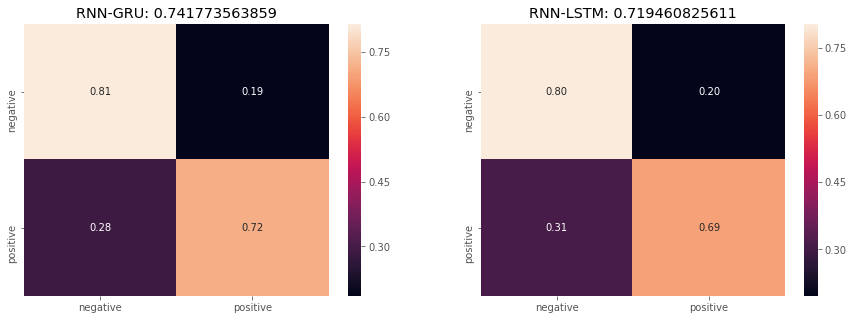

In [28]:
compare_models(rnn_gru, rnn_lstm, X_test, y_test)

It is clear from above visualization that the **recurrent neural architecture with GRU is a better performer** between the two architectures we modeled. This is also evident from the percentage values of true-negatives and true-positives along the diagonal of the matrix, which are greater for RNN-GRU.

### Statistical comparison using ROC and AUC

Let us perform a statistical comparison of the models using **Receiver Operating Characteristics (ROC)** and **Area under the Curve (AUC)**.

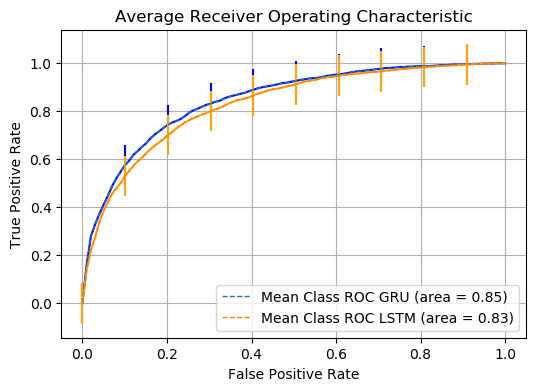

In [29]:
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

pred_1 = rnn_gru.predict(X_test)
pred_2 = rnn_lstm.predict(X_test)

# ROC for GRU
perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y_train)

# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                     pred_1[:,int(j)],
                                     pos_label=j)
    
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)

perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr
error = np.var(mean_fpr)
plt.style.use('default')

plt.figure(figsize=(6,4))
plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC GRU (area = %0.2f)'
               % (roc_auc))
plt.errorbar(mean_fpr, perclass_mean_tpr, yerr=error, barsabove=True, errorevery=10, color='blue')


# ROC for LSTM
perclass_mean_tpr = 0.0
roc_auc = 0

# get the mean fpr and tpr, per class
for j in classes:
    fpr, tpr, thresholds = roc_curve(y_test,
                                     pred_2[:,int(j)],
                                     pos_label=j)
    
    perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
    perclass_mean_tpr[0] = 0.0
    roc_auc += auc(fpr, tpr)

perclass_mean_tpr /= len(classes)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr

error = np.var(mean_fpr)


plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC LSTM (area = %0.2f)'
               % (roc_auc))
plt.errorbar(mean_fpr, perclass_mean_tpr, yerr=error, barsabove=True, errorevery=10, color='orange')

plt.legend(loc='best')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average Receiver Operating Characteristic')
plt.show()

From the above comparison, it appears that the LSTM architecture is not as good as the GRU architecture. The true positive rates of both the models have a slight difference between false positive rate of (~0.1 - ~0.4) along with the variance at each false positive value. After that point, both the curves appear to converge. Also, the area under the curve is greater for GRU, as shown in the graph.

Although the area under the curve tells us that GRU is better, let us compare the 2 models to see the statistical difference in their performances. To do this, we will use Binomial distribution to calculate the standard deviation in the error rates of the 2 models. For this comparision, we will be using a confidence interval of 95%.

Since the error bars shown in the graph above appear to overlap, we would like to go deeper into it to see the miniscule differences.

In [9]:
error_rate_gru = 1 - f1_gru
error_rate_lstm = 1 - f1_lstm

Z = 1.96 # at 95 % confidence
error_diff = np.abs(error_rate_gru - error_rate_lstm)
std_dev = ((error_rate_gru * (1-error_rate_gru)) + (error_rate_lstm * (1-error_rate_lstm))) / y_test.shape[0]

print("Range of:", error_diff - (Z * np.sqrt(std_dev)), error_diff + (Z * np.sqrt(std_dev)))

Range of: -0.0100210956875 0.0285610956875


Based on the test, the difference lies in the range of -1.0021% to 2.856%, which means that we cannot say for sure which model is better at 95% confidence interval. This could be an indication that any of these models can perform better than the other if we alter their architectural parameters a bit or train on more and different data whatsoever.

### Add a second recurrent chain

Now, we will add a second recurrent chain to the best architecture that we obtained previously which is RNN-GRU. We will be training this model on the same hyper-parameters as RNN-GRU and compare their performances. 

In [33]:
# https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
def rnn_model1_stacked(state_vector_size, embedding_layer):
    #create a custom embedding of output dimension 150
    embedding_layer_cust = Embedding(len(word_index) + 1,
                                150,
                                input_length=MAX_ART_LEN,
                                trainable=True,
                                name = "custom_embedding")
    rnn = Sequential()
    rnn.add(embedding_layer_cust)
    rnn.add(Dense(200, activation='relu'))
    rnn.add(Dropout(0.25))
    rnn.add(GRU(state_vector_size,dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape = (X_train.shape[1],)))
    rnn.add(GRU(state_vector_size, dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='softmax'))
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    
    return rnn

In [34]:
rnn_gru_stacked = rnn_model1_stacked(100, None)
print(rnn_gru_stacked.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
custom_embedding (Embedding) (None, 1000, 150)         4510500   
_________________________________________________________________
dense_19 (Dense)             (None, 1000, 200)         30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1000, 200)         0         
_________________________________________________________________
gru_5 (GRU)                  (None, 1000, 100)         90300     
_________________________________________________________________
gru_6 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 202       
Total params: 4,691,502
Trainable params: 4,691,502
Non-trainable params: 0
_________________________________________________________________


In [35]:
history_gru_stacked = rnn_gru_stacked.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=2, batch_size=64)
yhat = np.argmax(rnn_gru_stacked.predict(X_test), axis=1)
print("\nF-1 score:", mt.f1_score(y_test, yhat, average='binary'))

Train on 16000 samples, validate on 4000 samples
Epoch 1/2
16000/16000 [==============================] - 5129s 321ms/step - loss: 0.5709 - acc: 0.6985 - val_loss: 0.5093 - val_acc: 0.7592
Epoch 2/2
16000/16000 [==============================] - 5164s 323ms/step - loss: 0.4261 - acc: 0.8122 - val_loss: 0.5036 - val_acc: 0.7590

F-1 score: 0.751033057851


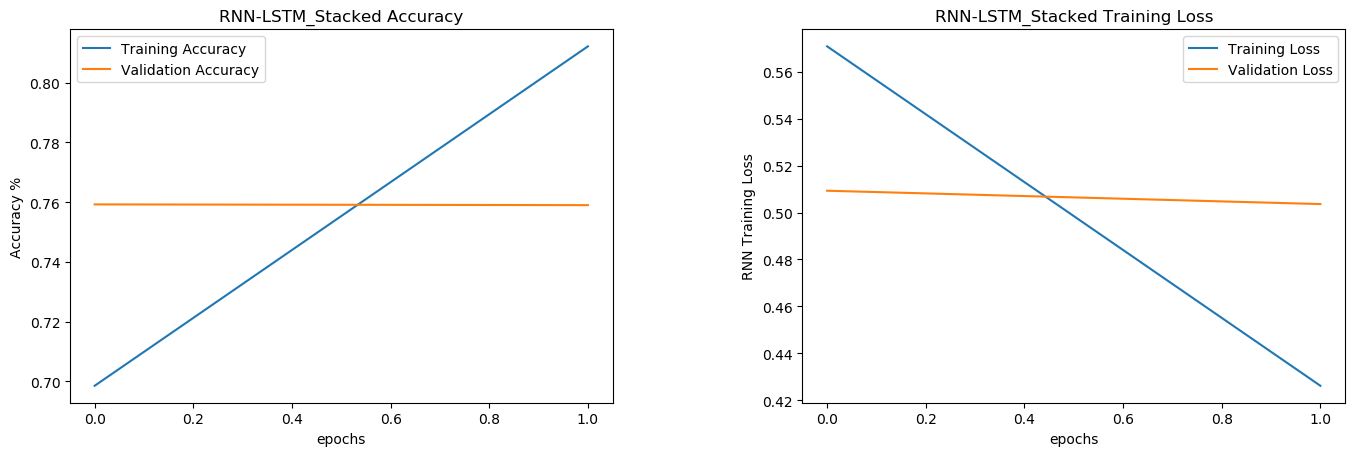

In [36]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.subplot(2,2,1)
plt.plot(history_gru_stacked.history['acc'], label="Training Accuracy")
plt.plot(history_gru_stacked.history['val_acc'], label="Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy %')
plt.title('RNN-LSTM_Stacked Accuracy')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.plot(history_gru_stacked.history['loss'], label="Training Loss")
plt.plot(history_gru_stacked.history['val_loss'], label="Validation Loss")
plt.xlabel('epochs')
plt.ylabel('RNN Training Loss')
plt.title('RNN-LSTM_Stacked Training Loss')
plt.legend(loc='best')

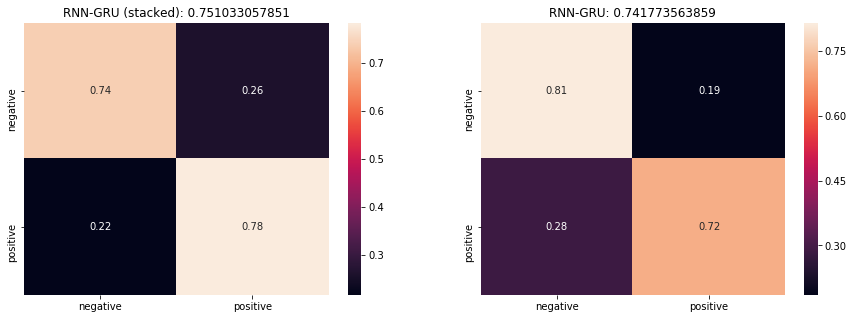

In [38]:
%matplotlib inline
plt.figure(figsize=(15,5))
if rnn_gru_stacked is not None:
    yhat_1 = np.argmax(rnn_gru_stacked.predict(X_test), axis=1)
    acc_1 = mt.f1_score(y_test,yhat_1, average='binary')
    plt.subplot(1,2,1)
    cm = mt.confusion_matrix(y_test,yhat_1)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(pd.DataFrame(cm, y_label, y_label), annot=True, fmt='.2f')
    plt.title('RNN-GRU (stacked): '+str(acc_1))

if rnn_gru is not None:
    yhat_2 = np.argmax(rnn_gru.predict(X_test), axis=1)
    acc_2 = mt.f1_score(y_test,yhat_2, average='binary')
    plt.subplot(1,2,2)
    cm = mt.confusion_matrix(y_test,yhat_2)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(pd.DataFrame(cm, y_label, y_label),annot=True, fmt='.2f')
    plt.title('RNN-GRU: '+str(acc_2))

Its clear! Adding a recurrent chain to our network *did* improve the performance, though with a small margin. It gave us a more balanced result between true-negative and true-positive scores. Hence, we can say that we can do much better with more recurrent chains and tuning.

# 4.Exceptional Work

In this section, we are going to visualize embeddings of subset of words used frequently in twitter along with some randomly chosen words from the glove embedding to populate the graph. 

In [40]:
def get_random_sample(length, embed):
    keys = random.sample(list(embed.keys()), length)
    values = [embed[i] for i in keys]
    return dict(zip(keys, values))

In [123]:
lists_of_words = [ 
    'hell', 'heaven', \
    'earth', 'mars', 'jupiter', 'pluto', 'venus', \
    'italy', 'france', 'germany', 'india', 'china', 'canada', 'mexico', 'japan', \
    'thanks', 'appreciate', 'gratitude', 'welcome', 'please', 'sorry', 'hi', \
    'delicious', 'yummy', 'awesome', 'dope', 'hilarious', 'gross'
]

In [125]:
for word in lists_of_words:
    for j in df['SentimentText']:
        if word in j:
            print(word+" is used in twitter at least once")
            break

hell is used in twitter at least once
heaven is used in twitter at least once
earth is used in twitter at least once
mars is used in twitter at least once
jupiter is used in twitter at least once
pluto is used in twitter at least once
venus is used in twitter at least once
italy is used in twitter at least once
france is used in twitter at least once
germany is used in twitter at least once
india is used in twitter at least once
china is used in twitter at least once
canada is used in twitter at least once
mexico is used in twitter at least once
japan is used in twitter at least once
thanks is used in twitter at least once
appreciate is used in twitter at least once
gratitude is used in twitter at least once
welcome is used in twitter at least once
please is used in twitter at least once
sorry is used in twitter at least once
hi is used in twitter at least once
delicious is used in twitter at least once
yummy is used in twitter at least once
awesome is used in twitter at least once
dop

In [127]:
def  tsne_plot (model, dimension):
    
    arr = np.empty((0,dimension), dtype='float32')
    word_labels = []
    # add the vector for each of the closest words to the array
    for word, embed in model.items():
        wrd_vector = embed
        word_labels.append(word)
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(75, 75))
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    matplotlib.rcParams.update({'font.size': 40})
    plt.show()

In [126]:
sample = get_random_sample(50, embeds_for_tsne)
logs = ['king', 'queen', 'boy', 'girl', 'man', 'woman', 'france', 'paris', 'italy', 'rome', 'ireland', 'dublin', \
       'europe', 'asia', 'africa', 'australia', 'apple', 'banana', 'orange']
list1.append(logs)
for logs in list1:
    for log in logs:
        sample[log] = embeds_for_tsne[log]

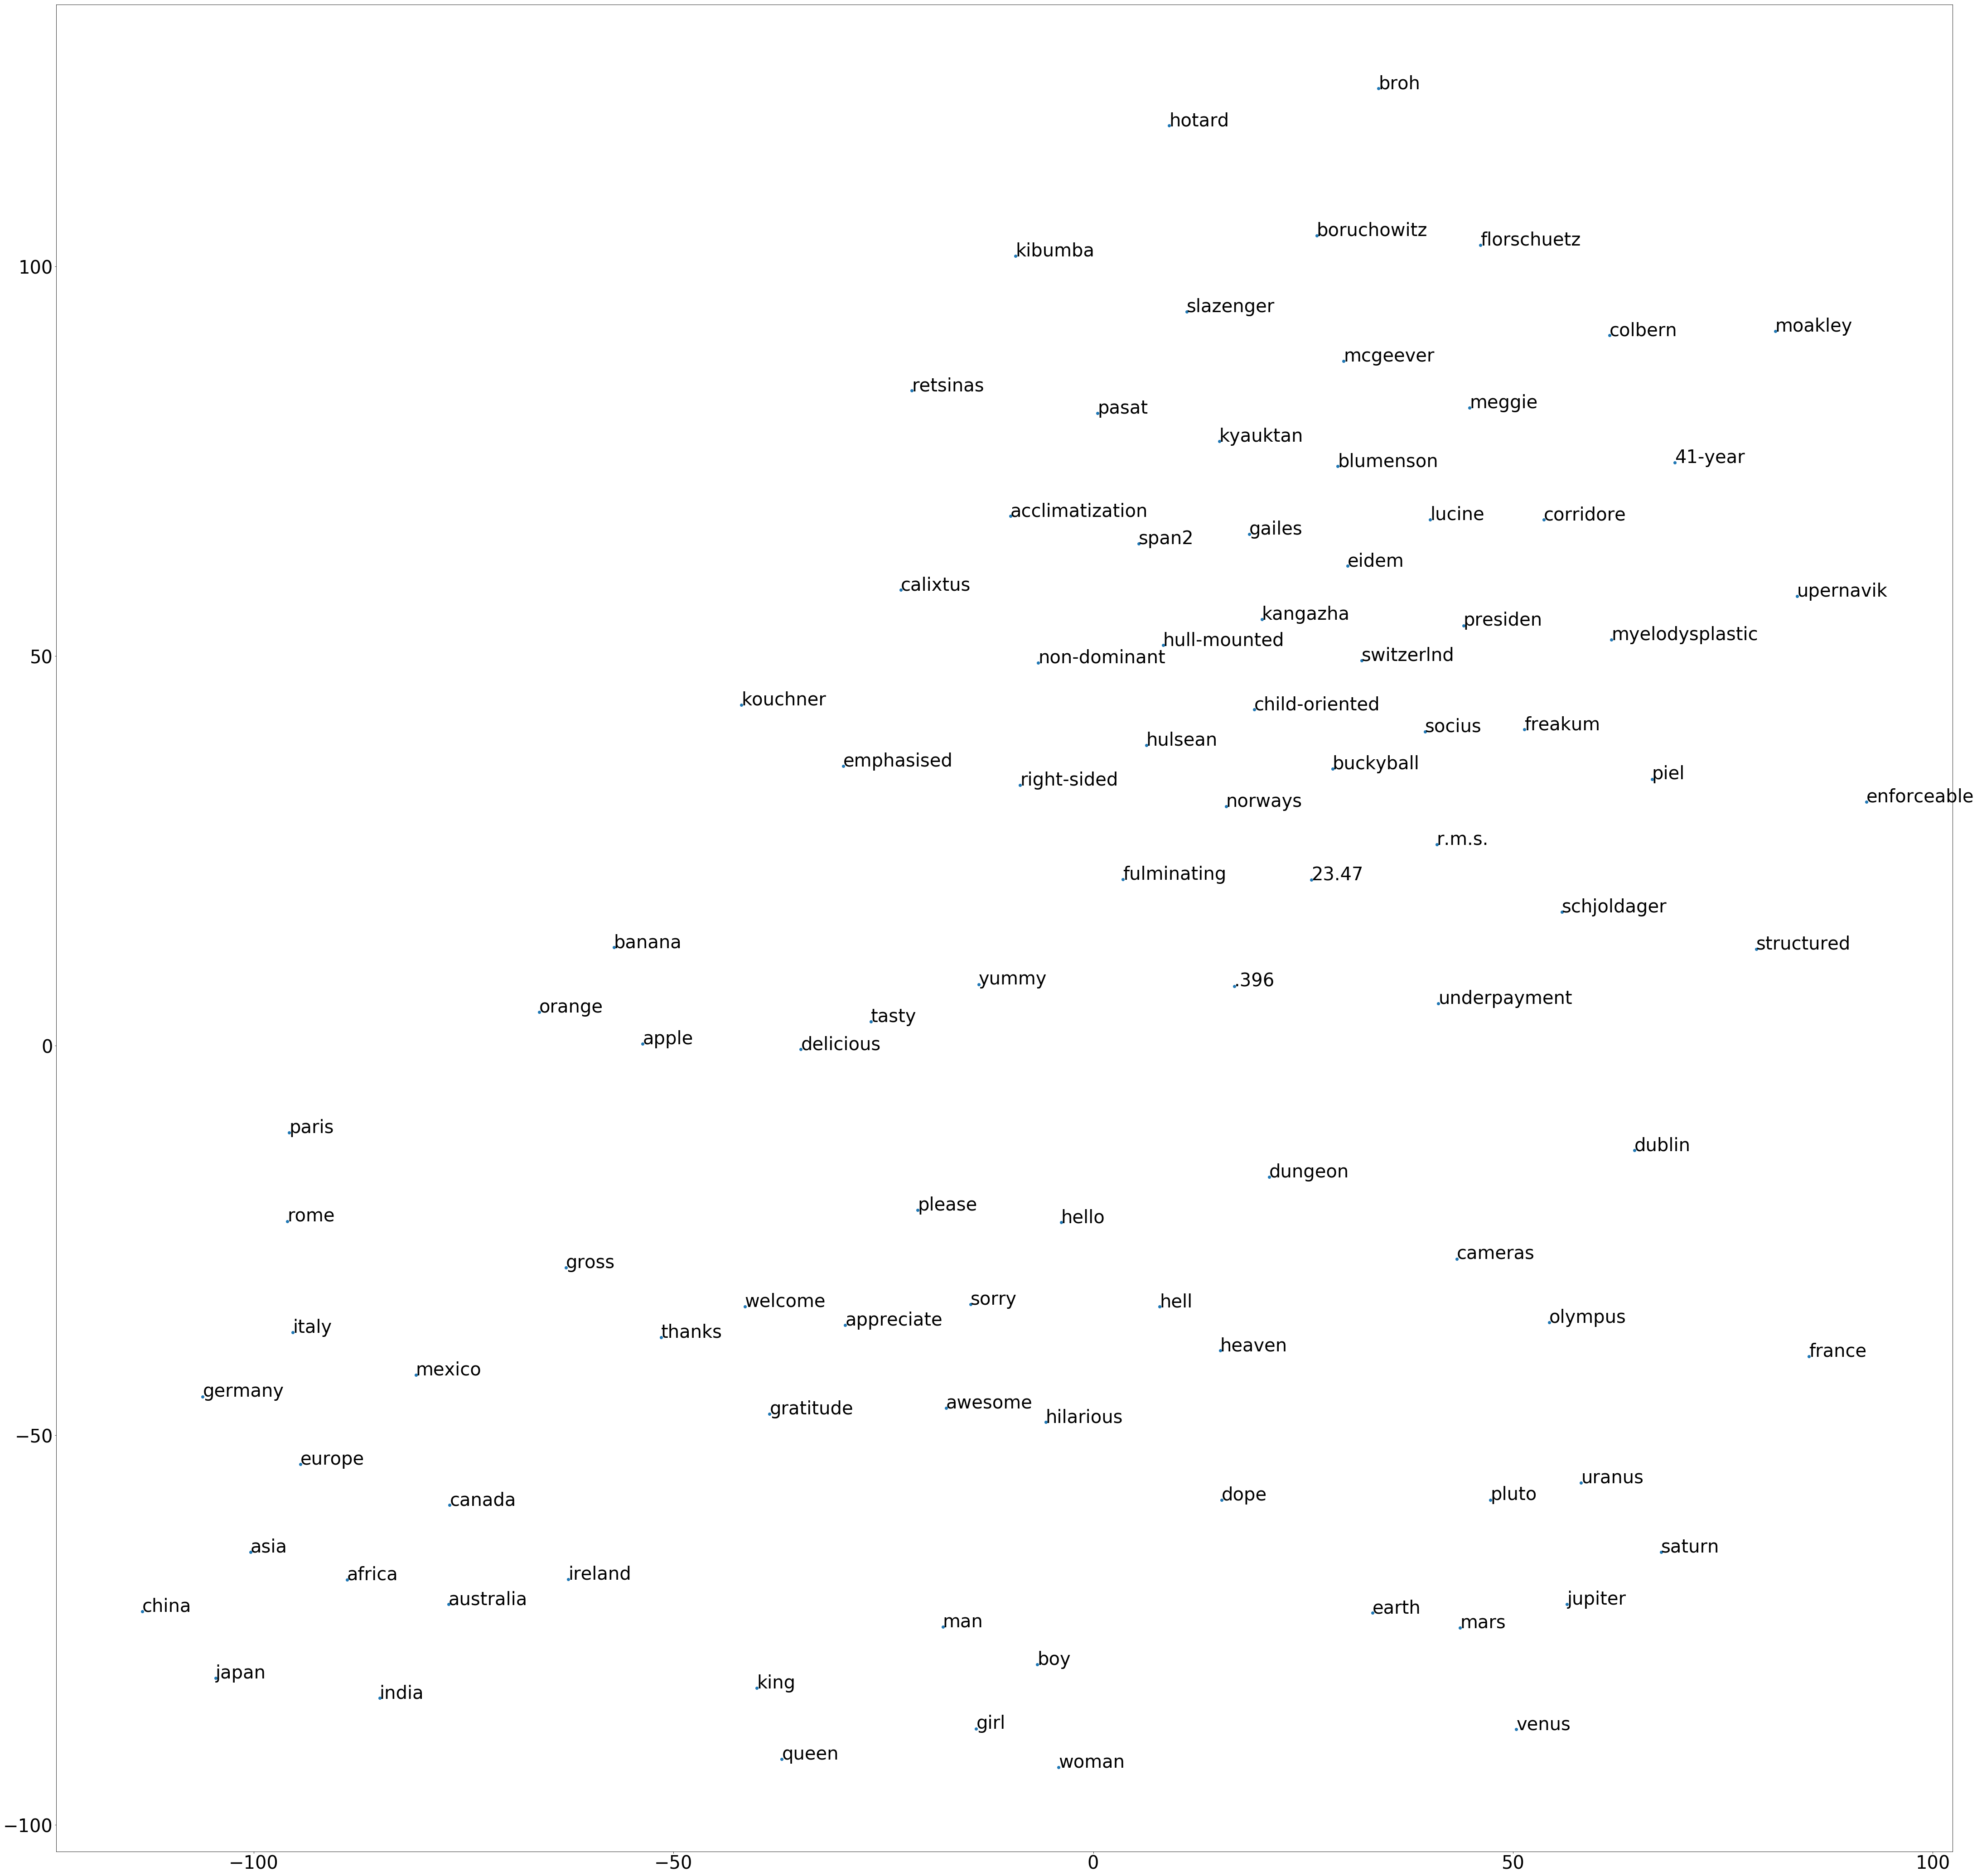

In [128]:
tsne_plot(sample, dimension=100)

From the above graph we can observe that the words which are similar in context or meaning have been clustered together such as [delicious, tasty, yummy], [hilarous, awesome], countries like [India, Rome, Paris, Japan, China] etc. These clusters represent various aspects of the word embeddings which are dimensionally reduced in the t-sne. 

We can use such clusters to identify words in the tweets which are closely related and belong to a particular category of sentiments. If we extend our model to classify multiple sentiments (instead of just positive and negative), this might prove to be vital for understanding how ready is our architecture for deployment.

## References

* https://www.kaggle.com/c/twitter-sentiment-analysis2

* https://github.com/smitheric95/machine-learning-labs/blob/master/Lab7

* http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html

* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

* https://www.marutitech.com/working-image-recognition/

* https://github.com/eclarson/MachineLearningNotebooks

* https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne/code

* https://www.webopedia.com/quick_ref/Twitter_Dictionary_Guide.asp